In [1]:
#!pip install --user pyarrow

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
conservation = pd.read_csv("../data/vep/conservation/Chr5.tsv.gz", sep="\t")
conservation

,pos,PhastCons,PhyloP
0,73,0.137841,0.486723
1,74,0.120058,0.630370
2,75,0.082986,-0.672660
3,76,0.083501,0.630370
4,77,0.070315,0.410230
...,...,...,...
24279498,26975493,0.149043,0.383414
24279499,26975494,0.139126,0.383414
24279500,26975495,0.121064,-0.819180
24279501,26975496,0.144156,0.383414


In [292]:
def compute_odds_ratio(df, threshold_quantile):
    df = df.copy()
    df.loc[df.model_score <= df.model_score.quantile(threshold_quantile), "ModelScoreTier"] = "Low"
    df.loc[df.model_score > df.model_score.quantile(threshold_quantile), "ModelScoreTier"] = "High"
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    try:
        group_counts = group_counts.values.reshape((2, 2))
    except:
        print("WARNING: count 0 in one bucket")
        return 1.0, 1.0
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    return odds_ratio, p_value


def compute_vep_scores(model_name):
    print(model_name)
    if model_name in ["PhastCons", "PhyloP", "PhyloP_ReLU", "PhyloP_abs"]:
        df = pd.read_parquet("../data/vep/variants/filt.parquet")
    else:
        vep_mode, model_name2 = model_name.split("/")
        df = pd.read_parquet(f"../plantbert/{vep_mode}/vep_full_{model_name2}.parquet")
    df = df[df.AN >= 2000]
    df = df[(df.AC != 0) & (df.AC != df.AN)]
    df["AF"] = df.AC / df.AN
    df = df[df.AF < 0.5]
    df = df.merge(conservation, how="inner", on="pos")
    df.consequence = df.consequence.apply(lambda x: ','.join(sorted(list(set(x.split(","))))))
    
    # TODO: figure this out
    #df.loc[(df.dist_to_TSS >= -1000) & (df.dist_to_TSS <= 0) & (df.consequence=="upstream_gene_variant"), "consequence"] = "upstream_1kb"
    
    # TODO: for loop
    #rare_thresholds = np.arange(2, 12, 2)
    #common_thresholds = np.arange(10, 110, 10)
    
    df["Status"] = "Neither"
    df.loc[df.AC <= 10, "Status"] = "Rare"
    df.loc[df.AC >= 100, "Status"] = "Common"
    df = df[df.Status!="Neither"]
    df.Status = df.Status.astype('category')
    print(df.Status.value_counts())
    #raise Exception("debug")
    
    if model_name == "PhastCons":
        df["model_score"] = -df.PhastCons
    elif model_name == "PhyloP":
        df["model_score"] = -(df.PhyloP)
    elif model_name == "PhyloP_abs":
        df["model_score"] = -(df.PhyloP.abs())
    elif model_name == "PhyloP_ReLU":
        df["model_score"] = -(df.PhyloP.clip(lower=0.0))
    elif vep_mode == "chromatin":
        pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
        pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
        pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
        df[pred_cols] = sigmoid(df[pred_cols])
        feature_names = ["_".join(col.split("_")[3:]) for col in pred_ref_cols]
        delta_pred_cols = [f"delta_pred_{f}" for f in feature_names]
        df.loc[:, delta_pred_cols] = df[pred_alt_cols].values - df[pred_ref_cols].values
        df.loc[:, "model_score"] = -np.linalg.norm(df[delta_pred_cols].abs().values, ord=2, axis=1)
    elif vep_mode == "mlm":
        df["model_score"] = df.model_llr
        
    threshold_quantiles = np.logspace(-3, -1, 10)
    
    categories = ["all"] + df.consequence.value_counts()[:8].index.values.tolist()
    
    all_results = []
    for category in categories:
        df_category = df if category == "all" else df[df.consequence==category]
        
        odds_ratios, p_values = zip(*[compute_odds_ratio(df_category, threshold_quantile) for threshold_quantile in threshold_quantiles])
        results = pd.DataFrame(dict(threshold_quantile=threshold_quantiles, odds_ratio=odds_ratios, p_value=p_values))
        results["Test"] = "Odds-ratio"
        
        results = results.append({
            "Test": "Mann-Whitney",
            "p_value": mannwhitneyu(df_category.loc[df.Status=="Rare", "model_score"], df_category.loc[df.Status=="Common", "model_score"], alternative="less").pvalue
        }, ignore_index=True)
        
        results = results.append({
            "Test": "AUROC",
            "AUROC": roc_auc_score((df_category.Status=="Rare").values, -df_category.model_score.values)
        }, ignore_index=True)
        
        precision, recall, thresholds = precision_recall_curve((df_category.Status=="Rare").values, -df_category.model_score.values)
        results = results.append({
            "Test": "AUPRC",
            "AUPRC": auc(recall, precision),
        }, ignore_index=True)
        
        results["Category"] = category
        all_results.append(results)
    all_results = pd.concat(all_results, ignore_index=True)
    all_results["Model"] = model_name
    all_results["Significant"] = all_results.p_value < 0.05
    
    return all_results, df

In [253]:
model_names = [
    "mlm/window-512_tokenization-no_model-convnet200k",
    "mlm/window-512_tokenization-no_model-convnet",
    "mlm/window-512_tokenization-no_model-convnet800k",
    "mlm/DNABERT",
    "chromatin/ConvNet",
    "chromatin/DNABERT",
    "chromatin/DeepSEA",
    "PhastCons",
    "PhyloP",
    #"PhyloP_ReLU",
    #"PhyloP_abs",
]

results = pd.concat(
    [compute_vep_scores(model_name)[0] for model_name in model_names],
    ignore_index=True
)

mlm/window-512_tokenization-no_model-convnet200k
Rare      827888
Common    175506
Name: Status, dtype: int64
mlm/window-512_tokenization-no_model-convnet
Rare      827888
Common    175506
Name: Status, dtype: int64
mlm/window-512_tokenization-no_model-convnet800k
Rare      827888
Common    175506
Name: Status, dtype: int64
mlm/DNABERT
Rare      827888
Common    175506
Name: Status, dtype: int64
chromatin/ConvNet
Rare      827888
Common    175506
Name: Status, dtype: int64
chromatin/DNABERT
Rare      827888
Common    175506
Name: Status, dtype: int64
chromatin/DeepSEA
Rare      827888
Common    175506
Name: Status, dtype: int64
PhastCons
Rare      827888
Common    175506
Name: Status, dtype: int64
PhyloP
Rare      827888
Common    175506
Name: Status, dtype: int64


In [255]:
#results.to_csv(f"vep_metrics_10_100.tsv", sep="\t", index=False)
results = pd.read_csv("vep_metrics_10_100.tsv", sep="\t")

In [256]:
results.Model.replace({"mlm/window-512_tokenization-no_model-convnet200k": "mlm/ConvNet-200k"}, inplace=True)
results.Model.replace({"mlm/window-512_tokenization-no_model-convnet": "mlm/ConvNet-400k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet-800k"}, inplace=True)
results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet"}, inplace=True)

In [257]:
# deal with infinite odds ratio
results.odds_ratio.max()

inf

In [258]:
results.odds_ratio.replace({np.inf: 10.0}, inplace=True)

In [259]:
results.odds_ratio.max()

11.875517847081827

In [260]:
#results = results[~(results.Model.isin(["PhyloP_abs", "PhyloP_ReLU"]))]

In [261]:
#results = results[results.Model.str.contains("mlm/ConvNet")]

In [262]:
results = results[~results.Model.str.contains("00k")]

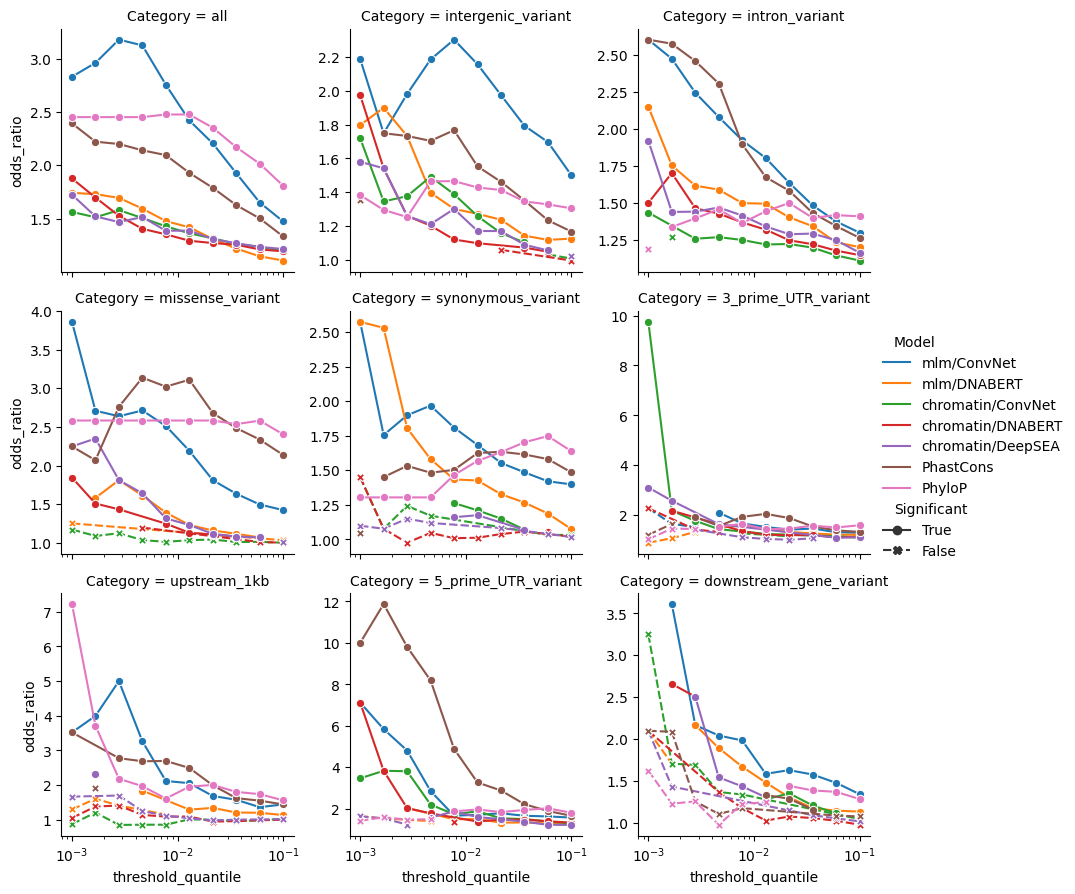

In [263]:
g = sns.relplot(
    data=results[results.Test=="Odds-ratio"],
    x="threshold_quantile",
    y="odds_ratio",
    hue="Model",
    style="Significant",
    style_order=[True, False],
    col="Category",
    height=3,
    #aspect=.7,
    kind="line",
    markers=True,
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': True}
)

g.set(xscale='log');
plt.savefig("odds_ratios.pdf", bbox_inches='tight')

In [264]:
results_mw = results[results.Test=="Mann-Whitney"]
results_mw

,threshold_quantile,odds_ratio,p_value,Test,AUROC,AUPRC,Category,Model,Significant
244,NaN,NaN,0.000000e+00,Mann-Whitney,NaN,NaN,all,mlm/ConvNet,True
257,NaN,NaN,2.420294e-97,Mann-Whitney,NaN,NaN,intergenic_variant,mlm/ConvNet,True
270,NaN,NaN,7.972113e-62,Mann-Whitney,NaN,NaN,intron_variant,mlm/ConvNet,True
283,NaN,NaN,1.073137e-111,Mann-Whitney,NaN,NaN,missense_variant,mlm/ConvNet,True
296,NaN,NaN,9.857605e-82,Mann-Whitney,NaN,NaN,synonymous_variant,mlm/ConvNet,True
...,...,...,...,...,...,...,...,...,...
998,NaN,NaN,2.708582e-245,Mann-Whitney,NaN,NaN,synonymous_variant,PhyloP,True
1011,NaN,NaN,8.310356e-73,Mann-Whitney,NaN,NaN,3_prime_UTR_variant,PhyloP,True
1024,NaN,NaN,2.654540e-49,Mann-Whitney,NaN,NaN,upstream_1kb,PhyloP,True
1037,NaN,NaN,1.909079e-66,Mann-Whitney,NaN,NaN,5_prime_UTR_variant,PhyloP,True


In [265]:
results_mw["-log10_pvalue"] = results_mw.p_value.apply(lambda p_value: 300 if p_value==0.0 else -np.log10(p_value))

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


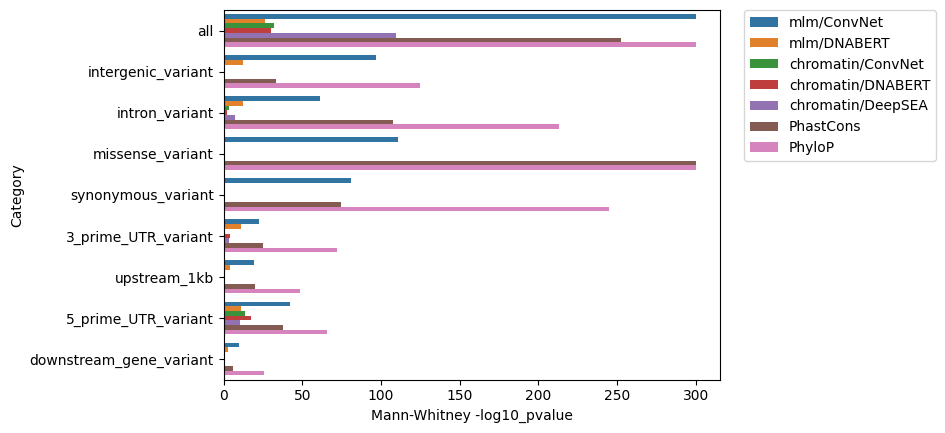

In [266]:
sns.barplot(
    y="Category",
    x="-log10_pvalue",
    hue="Model",
    data=results_mw,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Mann-Whitney -log10_pvalue")
plt.savefig("mann_whitney.pdf", bbox_inches='tight')

In [267]:
results_auroc = results[results.Test=="AUROC"]
results_auroc

,threshold_quantile,odds_ratio,p_value,Test,AUROC,AUPRC,Category,Model,Significant
245,NaN,NaN,NaN,AUROC,0.539500,NaN,all,mlm/ConvNet,False
258,NaN,NaN,NaN,AUROC,0.532339,NaN,intergenic_variant,mlm/ConvNet,False
271,NaN,NaN,NaN,AUROC,0.528229,NaN,intron_variant,mlm/ConvNet,False
284,NaN,NaN,NaN,AUROC,0.548688,NaN,missense_variant,mlm/ConvNet,False
297,NaN,NaN,NaN,AUROC,0.538826,NaN,synonymous_variant,mlm/ConvNet,False
...,...,...,...,...,...,...,...,...,...
999,NaN,NaN,NaN,AUROC,0.567905,NaN,synonymous_variant,PhyloP,False
1012,NaN,NaN,NaN,AUROC,0.563258,NaN,3_prime_UTR_variant,PhyloP,False
1025,NaN,NaN,NaN,AUROC,0.558749,NaN,upstream_1kb,PhyloP,False
1038,NaN,NaN,NaN,AUROC,0.570220,NaN,5_prime_UTR_variant,PhyloP,False


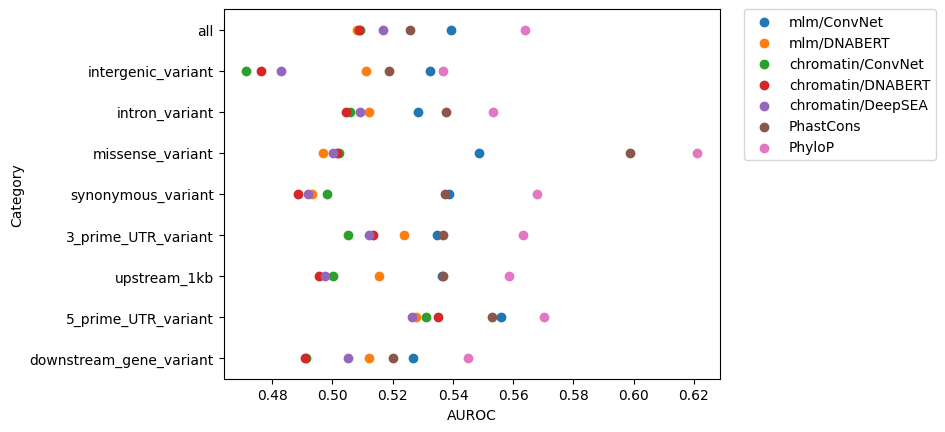

In [268]:
sns.pointplot(
    y="Category",
    x="AUROC",
    hue="Model",
    data=results_auroc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("auroc.pdf", bbox_inches='tight')

In [269]:
results_auprc = results[results.Test=="AUPRC"]
results_auprc

,threshold_quantile,odds_ratio,p_value,Test,AUROC,AUPRC,Category,Model,Significant
246,NaN,NaN,NaN,AUPRC,NaN,0.846851,all,mlm/ConvNet,False
259,NaN,NaN,NaN,AUPRC,NaN,0.877725,intergenic_variant,mlm/ConvNet,False
272,NaN,NaN,NaN,AUPRC,NaN,0.808097,intron_variant,mlm/ConvNet,False
285,NaN,NaN,NaN,AUPRC,NaN,0.875802,missense_variant,mlm/ConvNet,False
298,NaN,NaN,NaN,AUPRC,NaN,0.753635,synonymous_variant,mlm/ConvNet,False
...,...,...,...,...,...,...,...,...,...
1000,NaN,NaN,NaN,AUPRC,NaN,0.770462,synonymous_variant,PhyloP,False
1013,NaN,NaN,NaN,AUPRC,NaN,0.853058,3_prime_UTR_variant,PhyloP,False
1026,NaN,NaN,NaN,AUPRC,NaN,0.865951,upstream_1kb,PhyloP,False
1039,NaN,NaN,NaN,AUPRC,NaN,0.866333,5_prime_UTR_variant,PhyloP,False


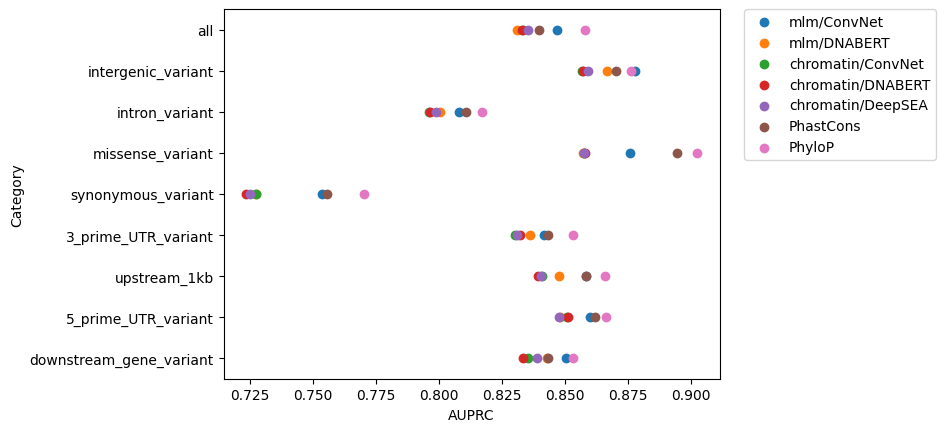

In [270]:
sns.pointplot(
    y="Category",
    x="AUPRC",
    hue="Model",
    data=results_auprc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("auprc.pdf", bbox_inches='tight')

In [249]:
#df1 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half1_DNABERT.parquet")
#df2 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half2_DNABERT.parquet")
#df = pd.concat([df1, df2], ignore_index=True)
#df.to_parquet("../plantbert/chromatin/vep_full_DNABERT.parquet", index=False)

<AxesSubplot:>

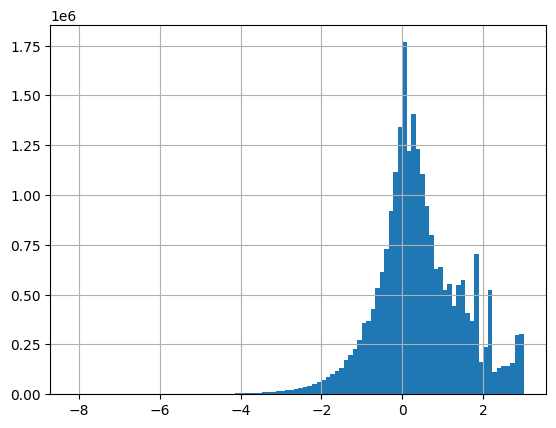

In [272]:
conservation.PhyloP.hist(bins=100)

In [273]:
conservation.PhyloP.describe()

count    2.427950e+07
mean     4.074203e-01
std      1.082959e+00
min     -8.143305e+00
25%     -1.906164e-01
50%      2.944243e-01
75%      1.049073e+00
max      3.008361e+00
Name: PhyloP, dtype: float64

In [326]:
df = compute_vep_scores("mlm/window-512_tokenization-no_model-convnet800k")[1]
#df = compute_vep_scores("PhyloP")[1]
df

mlm/window-512_tokenization-no_model-convnet800k
Rare      827888
Common    175506
Name: Status, dtype: int64


,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,model_score
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.548594,0.180943,4.065988e-05,-2.247958,Common,1.548594
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.533616,0.000958,5.789353e-03,-0.031569,Rare,-1.533616
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.993099,0.001896,2.593449e-05,-2.233914,Rare,-0.993099
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.297340,0.002828,8.936376e-02,1.008387,Rare,1.297340
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.701311,0.000941,4.240783e-03,0.006849,Rare,0.701311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319365,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-1.215929,0.002893,3.660736e-01,1.170096,Rare,-1.215929
1319366,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.032679,0.000976,1.420844e-05,-1.248585,Rare,-0.032679
1319367,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,1.066617,0.002938,8.210040e-07,-4.405118,Rare,1.066617
1319368,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-0.765276,0.001957,2.430046e-02,1.170096,Rare,-0.765276


In [327]:
consequence_scores = df.groupby("consequence").agg({"model_score": "mean", "pos": "size"}).rename(columns={"model_score": "mean_model_score", "pos": "counts"}).reset_index()
consequence_scores = consequence_scores[~consequence_scores.consequence.str.contains(',')]
consequence_scores = consequence_scores.sort_values("mean_model_score")
consequence_scores.sort_values("mean_model_score")

,consequence,mean_model_score,counts
475,non_coding_transcript_variant,-2.746001,3
484,splice_donor_variant,-2.430896,383
500,stop_gained,-2.314429,2740
497,start_lost,-1.705586,208
480,splice_acceptor_variant,-1.613248,362
146,5_prime_UTR_variant,-0.387562,36206
433,missense_variant,-0.338248,143827
333,intergenic_variant,-0.295855,292426
512,upstream_gene_variant,-0.265307,42551
459,non_coding_transcript_exon_variant,-0.210005,7063


In [328]:
consequence_scores = consequence_scores[consequence_scores.counts >= 100]
consequence_scores

,consequence,mean_model_score,counts
484,splice_donor_variant,-2.430896,383
500,stop_gained,-2.314429,2740
497,start_lost,-1.705586,208
480,splice_acceptor_variant,-1.613248,362
146,5_prime_UTR_variant,-0.387562,36206
433,missense_variant,-0.338248,143827
333,intergenic_variant,-0.295855,292426
512,upstream_gene_variant,-0.265307,42551
459,non_coding_transcript_exon_variant,-0.210005,7063
504,stop_lost,-0.208576,187


In [329]:
consequence_scores["consequence"] = consequence_scores.consequence + " (n=" + consequence_scores.counts.astype(str) + ")"
consequence_scores

,consequence,mean_model_score,counts
484,splice_donor_variant (n=383),-2.430896,383
500,stop_gained (n=2740),-2.314429,2740
497,start_lost (n=208),-1.705586,208
480,splice_acceptor_variant (n=362),-1.613248,362
146,5_prime_UTR_variant (n=36206),-0.387562,36206
433,missense_variant (n=143827),-0.338248,143827
333,intergenic_variant (n=292426),-0.295855,292426
512,upstream_gene_variant (n=42551),-0.265307,42551
459,non_coding_transcript_exon_variant (n=7063),-0.210005,7063
504,stop_lost (n=187),-0.208576,187


Text(0, 0.5, '')

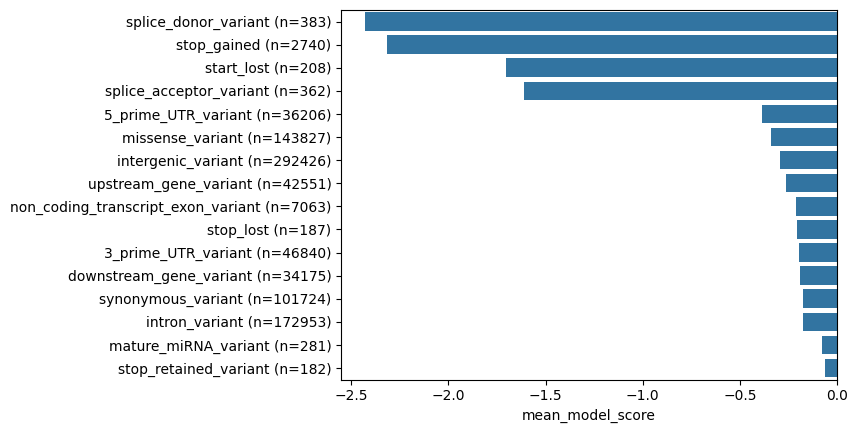

In [330]:
sns.barplot(
    data=consequence_scores,
    y="consequence", x="mean_model_score", color="C0"
);
plt.ylabel("")